In [1]:
%matplotlib inline

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy

In [3]:
import pyiq

In [4]:
plt.rcParams["figure.constrained_layout.use"] = "True"
mpl.rcParams["image.interpolation"] = "nearest"
mpl.rcParams["image.cmap"] = "gray"

# 2D NPS

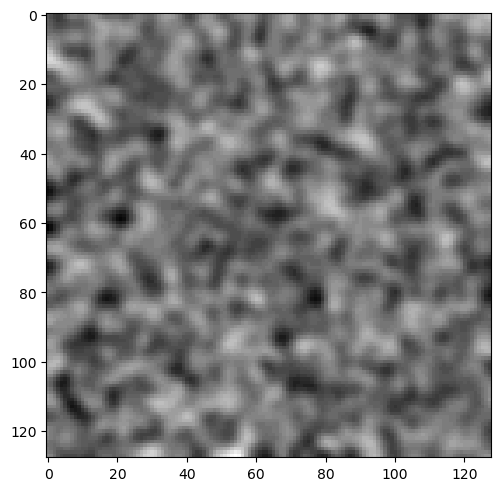

In [5]:
pxsize = 1e-3
im = np.random.poisson(1000, (128, 128))
im = scipy.ndimage.gaussian_filter(im, 2e-3 / pxsize)
plt.imshow(im, interpolation="nearest")

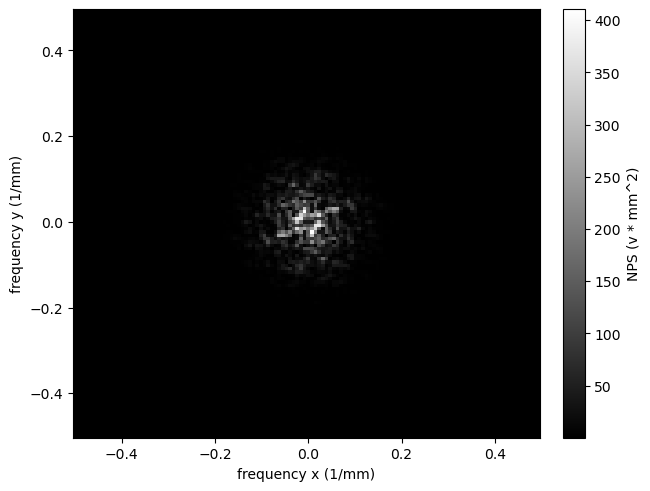

In [6]:
nps = pyiq.powerspectrum(im, pxsize=pxsize)
fy, fx = pyiq.psfreq(im.shape, pxsize=pxsize)
plotunit = 1e-3
plt.pcolormesh(fy * plotunit, fx * plotunit, nps * (1 / plotunit) ** 2)
plt.xlabel("frequency x (1/mm)")
plt.ylabel("frequency y (1/mm)")
plt.colorbar(label="NPS (v * mm^2)")

In [7]:
fbinspx, nps1d = pyiq.azimuthal_average(nps * (1 / plotunit) ** 2, coords=(fy, fx), center=(0,0))
plt.plot(fbins, nps1d)
plt.xlabel("frequency x (1/mm)")
plt.ylabel("NPS (v * mm^2)")

ValueError: zero-size array to reduction operation minimum which has no identity

# 2D NPS of a stack

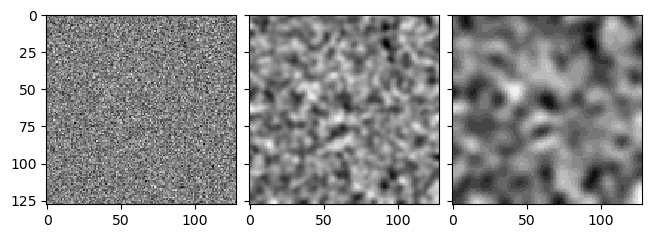

In [ ]:
pxsize = 1e-3
im = np.random.poisson(1000, (128, 128))
im = np.array(
    [
        scipy.ndimage.gaussian_filter(im, sigma / pxsize)
        for sigma in np.linspace(0, 4, num=3) * 1e-3
    ]
)
fig, axs = plt.subplots(ncols=3, sharey="row")
for i in range(3):
    axs[i].imshow(im[i, ...])

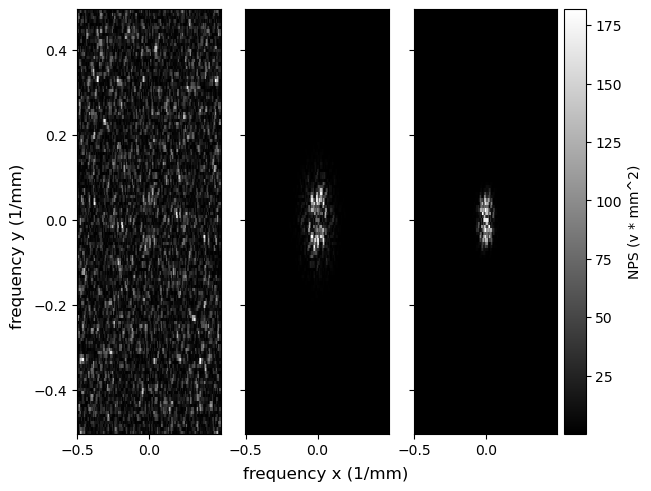

In [ ]:
nps = pyiq.powerspectrum(im, pxsize=pxsize, axis=(-2, -1))
fy, fx = pyiq.psfreq(im.shape[-2:], pxsize=pxsize)

fig, axs = plt.subplots(ncols=3, sharey="row")
for i in range(3):
    cm = axs[i].pcolormesh(
        fy * plotunit, fx * plotunit, nps[i, ...] * (1 / plotunit) ** 2
    )
fig.supxlabel("frequency x (1/mm)")
fig.supylabel("frequency y (1/mm)")
fig.colorbar(cm, label="NPS (v * mm^2)")

# 3D NPS

In [ ]:
pxsize = np.array([5e-3, 1e-3, 1e-3])
im = np.random.poisson(1000, (16, 128, 128))
im = scipy.ndimage.gaussian_filter(im, sigma=1e-3 / pxsize)

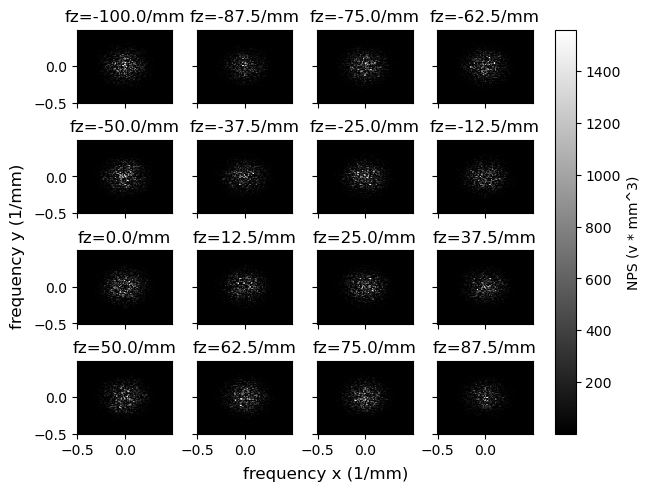

In [ ]:
nps = pyiq.powerspectrum(im, pxsize=pxsize, axis=(0, 1, 2))
fz, fy, fx = pyiq.psfreq(im.shape, pxsize=pxsize, axis=(0, 1, 2))

fig, axs = plt.subplots(ncols=4, nrows=4, sharey="all", sharex="all")
for ax, iz in zip(axs.ravel(), range(16)):
    cm = ax.pcolormesh(fy * plotunit, fx * plotunit, nps[iz, ...] * (1 / plotunit) ** 3)
    ax.set_title(f"fz={fz[iz]:.1f}/mm")
fig.supxlabel("frequency x (1/mm)")
fig.supylabel("frequency y (1/mm)")
fig.colorbar(cm, ax=axs, label="NPS (v * mm^3)")

# Detectability index

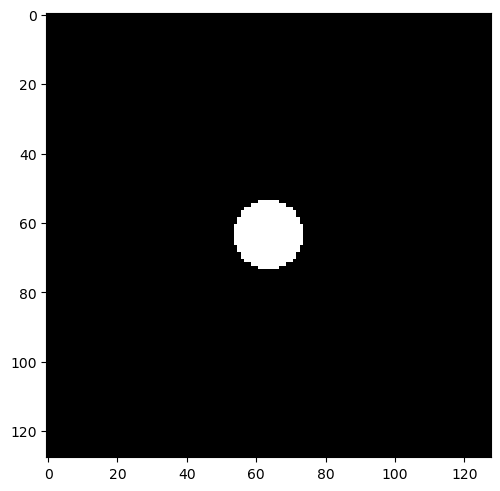

In [ ]:
pxsize = 1e-3
w = pyiq.task_disc((128, 128), radius=10, value=20)
plt.imshow(w)

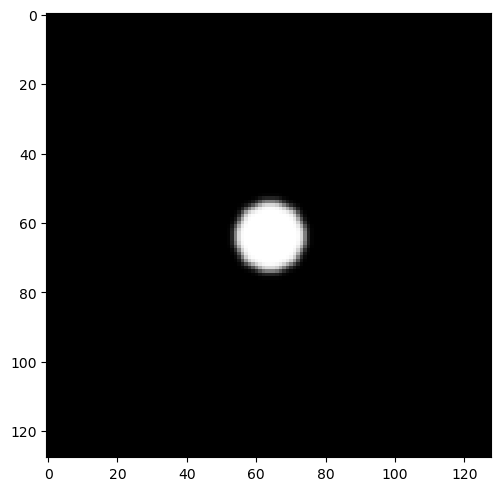

In [ ]:
# finite point-spread function
psf1d = scipy.signal.windows.gaussian(128, std=1e-3 / pxsize)
psf = psf1d[:, np.newaxis] * psf1d[np.newaxis, :]
psf /= psf.sum()
wpsf = scipy.signal.convolve2d(w, psf, mode="same")
plt.imshow(wpsf)

Text(0, 0.5, 'task transfer function (TTF)')

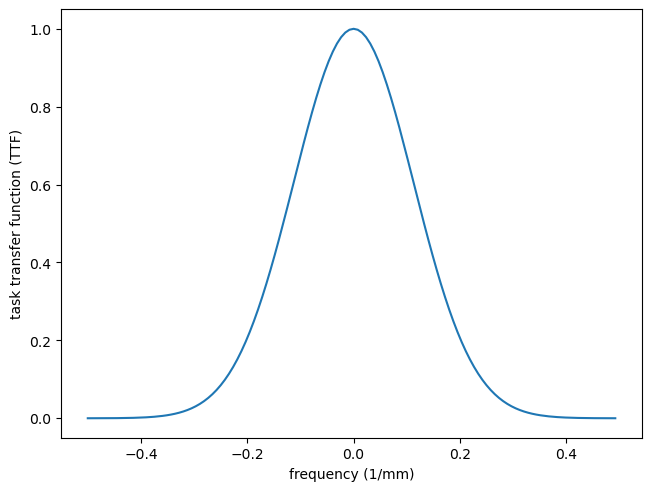

In [ ]:
ttf = np.fft.fftshift(np.abs(np.fft.fft(psf1d)))**2
ttffreq = np.fft.fftshift(np.fft.fftfreq(psf1d.size, d=pxsize))
ttf /= np.sum(psf1d)**2

plt.plot(ttffreq * plotunit, ttf)
plt.xlabel("frequency (1/mm)")
plt.ylabel("task transfer function (TTF)")

Text(0.5, 1.0, 'alternative hypothesis (disc present)')

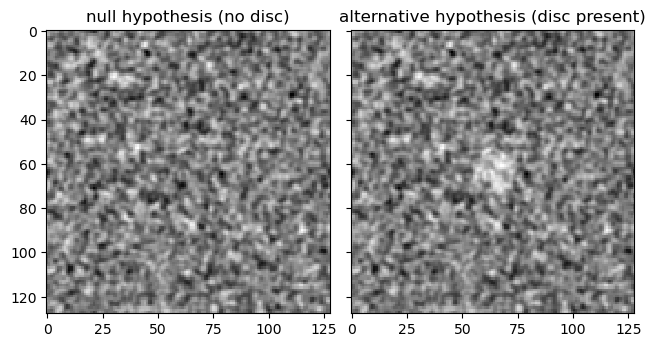

In [ ]:
im = np.random.poisson(1000, (128, 128))
nps = pyiq.powerspectrum(im, pxsize=pxsize)

im0 = scipy.signal.convolve2d(im, psf, mode="same", boundary="wrap")
im1 = im0 + wpsf

fig, axs = plt.subplots(ncols=2, sharey="all")
axs[0].imshow(im0)
axs[0].set_title("null hypothesis (no disc)")
axs[1].imshow(im1)
axs[1].set_title("alternative hypothesis (disc present)")

In [ ]:
W = pyiq.powerspectrum(w, window=None, pxsize=pxsize)
pyiq.dprime(W, nps)

33.10420151046973

/Users/mrawlik/code/pyiq/pyiq.py:128: RuntimeWarning: invalid value encountered in scalar divide
  dp = np.sqrt(np.sum(a, axis=axis) ** 2 / np.sum(a * nps, axis=axis))


(0.0, 17.268384729966346)

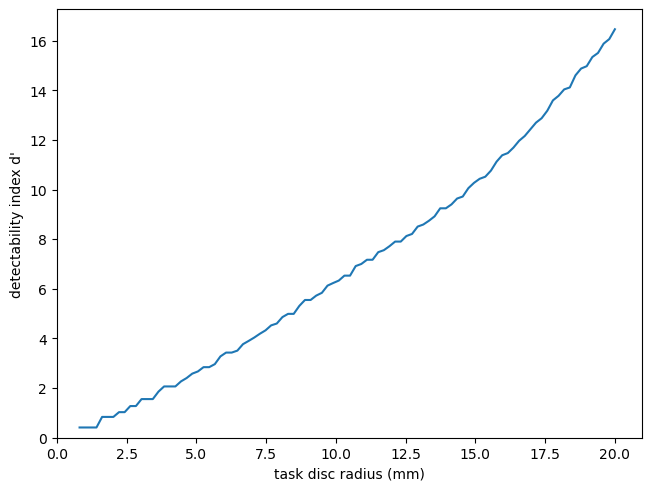

In [ ]:
radii = np.linspace(0, 20, num=100)
dp = [
    pyiq.dprime(
        taskps=pyiq.powerspectrum(
            pyiq.task_disc((128, 128), radius=r, value=4), window=None, pxsize=pxsize
        ),
        nps=nps,
        ttf=ttf
    )
    for r in radii
]

plt.plot(radii * pxsize / plotunit, dp)
plt.xlabel("task disc radius (mm)")
plt.ylabel("detectability index d'")
plt.xlim(left=0)
plt.ylim(bottom=0)